In [128]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if rd not in sys.path:
    sys.path.append(rd)

# Import data

In [41]:
constrained = 'singly'

In [151]:
# Import retail data
cost_matrix = np.loadtxt('../data/input/retail/cost_matrix.txt')
origin_supply = np.loadtxt('../data/input/retail/origin_supply.txt')
initial_destination_sizes = np.loadtxt('../data/input/retail/initial_destination_sizes.txt')
rsquared_analysis = np.loadtxt("../cities_and_regions/output/rsquared_analysis.txt")

data = np.loadtxt("../cities_and_regions/data/london_n/shopping_small.txt")
popn = np.loadtxt("../cities_and_regions/data/london_n/popn.txt")
xd = np.loadtxt("../cities_and_regions/data/london_n/xd0.txt")

origin_locs = popn[:, [0, 1]]
destination_locs = data[:, [0, 1]]

mcmc_low_noise_theta_samples_init = np.loadtxt("../cities_and_regions/output/low_noise_samples.txt")
mcmc_low_noise_x_samples_init = np.loadtxt("../cities_and_regions/output/low_noise_samples2.txt")
mcmc_low_noise_sign_samples_init = np.loadtxt("../cities_and_regions/output/low_noise_samples3.txt")

N,M = cost_matrix.shape

In [152]:
np.sum(data[:,[2]])

4405709.0

In [153]:
np.sum(origin_supply)

1.0

In [154]:
np.max(rsquared_analysis)

0.9019837895702899

In [155]:
0.3/M

0.006122448979591836

In [156]:
np.min(initial_destination_sizes)

0.00617494255748621

In [157]:
np.sum(initial_destination_sizes)

1.0

In [158]:
np.sum(cost_matrix)

1.0

In [159]:
np.max(cost_matrix)

0.00012041250708713227

In [160]:
np.min(cost_matrix)

0.0

In [161]:
beta = 28000

In [162]:
np.min(np.exp(-cost_matrix*beta))

0.03433636788110734

In [163]:
np.max(np.exp(-cost_matrix*beta))

1.0

# MCMC sampling

In [164]:
# Select mcmc start
mcmc_start = 1

In [165]:
theta_min = np.min(mcmc_low_noise_theta_samples_init,axis=0)
theta_max = np.max(mcmc_low_noise_theta_samples_init,axis=0)

print('Theta')
print(f'min = {theta_min}')
print(f'max = {theta_max}')

Theta
min = [1.14301849 0.22233999]
max = [1.20727509 0.29199527]


In [166]:
w_min = np.exp(np.min(mcmc_low_noise_x_samples_init,axis=0))
w_max = np.exp(np.max(mcmc_low_noise_x_samples_init,axis=0))

print('X')
print(f'min = {w_min}')
print(f'max = {w_max}')

X
min = [0.20236861 0.02320989 0.01806903 0.02013347 0.016055   0.02258139
 0.01453172 0.01678071 0.0224074  0.01194123 0.01396338 0.02084862
 0.02213392 0.0132242  0.00674286 0.00724915 0.0119439  0.00763987
 0.00717151 0.00771306 0.00918291 0.00799285 0.00697109 0.00766888
 0.01053843 0.00833604 0.00642163 0.00680825 0.00681838 0.00808389
 0.00839645 0.01186566 0.01305519 0.00772339 0.00692581 0.00540522
 0.01206806 0.01016102 0.00716161 0.00656368 0.00937112 0.00918474
 0.01017619 0.01147082 0.00886922 0.00742381 0.00921476 0.00658478
 0.00693617]
max = [0.2920245  0.04652204 0.031625   0.03883611 0.03062416 0.03993206
 0.02884935 0.03233411 0.03609767 0.02051108 0.02578025 0.03462958
 0.04335924 0.02305386 0.01391606 0.01321997 0.02155474 0.01554249
 0.01501998 0.01332051 0.01710376 0.01595043 0.01349164 0.01522357
 0.0212861  0.01626487 0.01374853 0.01309519 0.0144151  0.01570338
 0.01805315 0.02372065 0.02505875 0.01478598 0.0131841  0.01164949
 0.02293799 0.01916731 0.01482649 0

In [167]:
sign_min = np.min(mcmc_low_noise_sign_samples_init,axis=0)
sign_max = np.max(mcmc_low_noise_sign_samples_init,axis=0)

print('X')
print(f'min = {sign_min}')
print(f'max = {sign_max}')

X
min = 1.0
max = 1.0


In [168]:
# Initialisations 
print('theta')
print(mcmc_low_noise_theta_samples_init[:mcmc_start+1])

print('x')
print(mcmc_low_noise_x_samples_init[:mcmc_start+1])
print('true x')
print(xd)

print('sign')
print(mcmc_low_noise_theta_samples_init[:mcmc_start+1])

theta
[[1.17097421 0.25761399]
 [1.17093182 0.25202934]]
x
[[-1.40985754 -3.09458228 -3.48816872 -3.90537175 -3.7423204  -3.48238964
  -3.79974684 -3.43163245 -3.66894133 -4.25558083 -3.91555429 -3.71324914
  -3.19624656 -4.32570667 -4.52965777 -4.61842047 -3.96934135 -4.53634339
  -4.55682268 -4.53580973 -4.36144747 -4.48172112 -4.58625992 -4.57842881
  -4.31459852 -4.55963463 -4.88689429 -4.7928993  -4.68079439 -4.50104671
  -4.50845557 -4.09284085 -4.02958396 -4.55971097 -4.80377157 -4.85345867
  -4.05864181 -4.38481225 -4.65200123 -4.77735801 -4.45483675 -4.50360075
  -4.22594196 -4.11071436 -4.56539446 -4.62870489 -4.49440255 -4.89290679
  -4.68390095]
 [-1.35773336 -3.06782912 -3.68647877 -3.34043021 -3.93426262 -3.61416109
  -3.79156629 -3.95765908 -3.39120472 -4.26572208 -4.07075878 -3.48844623
  -3.63421524 -3.79427778 -4.74829707 -4.70493891 -4.19225328 -4.54362445
  -4.69042757 -4.67386628 -4.33672761 -4.4728943  -4.65694801 -4.65996815
  -4.43418611 -4.69683698 -4.88115673 

## Visualise X initialisations

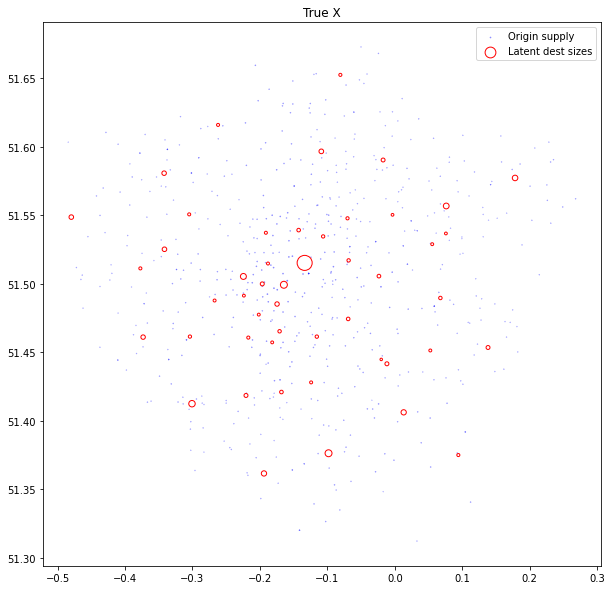

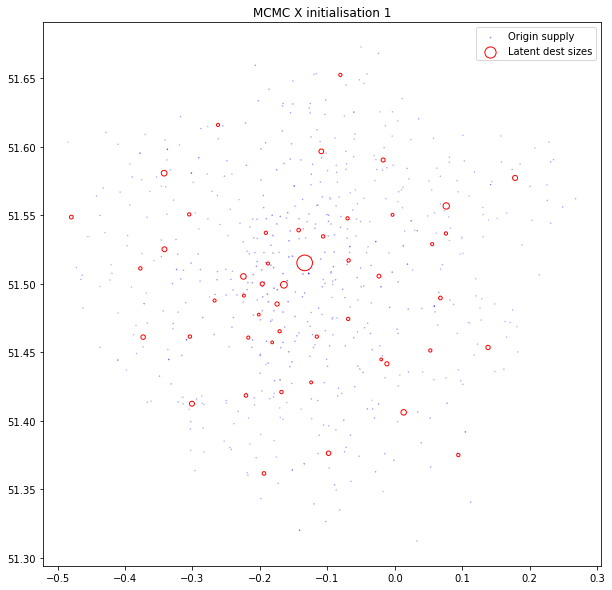

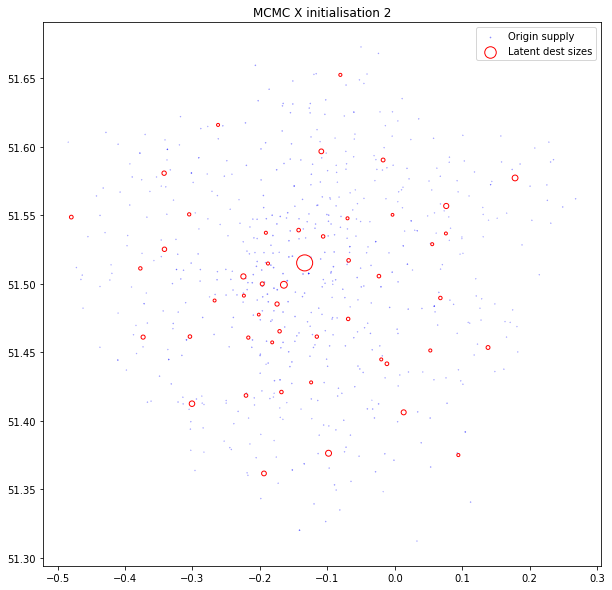

In [169]:
xx1 = mcmc_low_noise_x_samples_init[:mcmc_start+1][0]
xx2 = mcmc_low_noise_x_samples_init[:mcmc_start+1][1]

plt.figure(0,figsize=(10,10))
plt.title("True X")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xd),label='Latent dest sizes')
plt.legend()

plt.figure(1,figsize=(10,10))
plt.title("MCMC X initialisation 1")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx1),label='Latent dest sizes')
plt.legend()

plt.figure(2,figsize=(10,10))
plt.title("MCMC X initialisation 2")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx2),label='Latent dest sizes')
plt.legend()

# MCMC samples

## Low noise

In [170]:
samples = np.loadtxt(os.path.join(rd,f"data/output/retail/inverse_problem/{constrained}_low_noise_theta_samples.txt"))
samples2 = np.loadtxt(os.path.join(rd,f"data/output/retail/inverse_problem/{constrained}_low_noise_logsize_samples.txt"))
samples3 = np.loadtxt(os.path.join(rd,f"data/output/retail/inverse_problem/{constrained}_low_noise_sign_samples.txt"))


In [171]:
np.mean(samples,axis=0)

array([1.1741832 , 0.26132347])

In [172]:
posterior_xd = np.mean(samples2,axis=0)

In [173]:
np.exp(posterior_xd)

array([0.24909405, 0.03164969, 0.02378241, 0.02971315, 0.02208961,
       0.03004968, 0.0201982 , 0.0226663 , 0.0285878 , 0.01521502,
       0.01967454, 0.02678742, 0.02958612, 0.01742751, 0.00966036,
       0.00995346, 0.01644223, 0.01081833, 0.01037358, 0.01027272,
       0.01247685, 0.01120156, 0.00987907, 0.01089274, 0.01508253,
       0.01142164, 0.00969515, 0.0094594 , 0.01011681, 0.01119705,
       0.01230408, 0.01657229, 0.01810786, 0.01122316, 0.0094718 ,
       0.00806375, 0.01658755, 0.01386569, 0.01058249, 0.00945339,
       0.01308438, 0.01311545, 0.01536369, 0.0170614 , 0.0122012 ,
       0.01048661, 0.01270121, 0.00945302, 0.01026969])

In [174]:
np.exp(xd)

array([0.22622378, 0.04804487, 0.02782798, 0.04806237, 0.02079757,
       0.03511406, 0.02171166, 0.02020781, 0.03055409, 0.02079053,
       0.01971031, 0.04167333, 0.03319362, 0.02801797, 0.00773403,
       0.00903789, 0.01540125, 0.0092022 , 0.00894584, 0.00924584,
       0.01286422, 0.0092972 , 0.00946198, 0.00848471, 0.01180628,
       0.00998493, 0.00815949, 0.00788244, 0.00867721, 0.01075333,
       0.01117946, 0.01563602, 0.01940395, 0.01120878, 0.00880153,
       0.00618291, 0.01571988, 0.0156867 , 0.00835835, 0.00739904,
       0.01062583, 0.01263286, 0.01342876, 0.01521034, 0.01165764,
       0.00957925, 0.01291104, 0.00811858, 0.00868039])

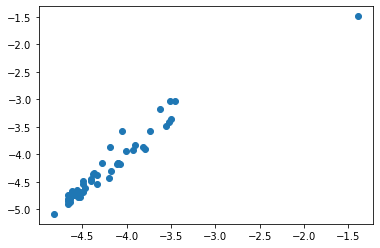

In [175]:
plt.scatter(posterior_xd,xd)

In [176]:
np.corrcoef(posterior_xd,xd)[0,1]

0.9665879236618373

(array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 21000.],
        [21000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]]),
 array([0.22233999, 0.3208335 , 0.41932701, 0.51782052, 0.61631403,
        0.71480754, 0.81330105, 0.91179456, 1.01028807, 1.10878158,
        1.20727509]),
 <a list of 2 Lists of Patches objects>)

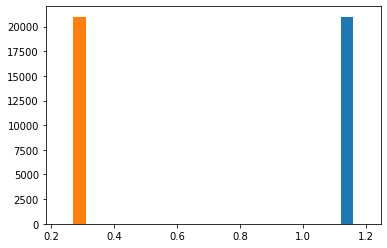

In [177]:
plt.hist(samples)

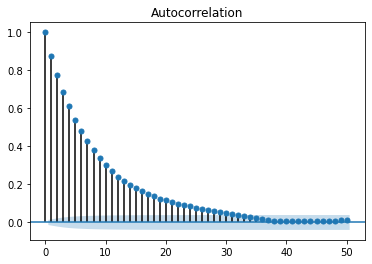

In [184]:
sm.graphics.tsa.plot_acf(samples[:,0], lags=50)
plt.show()

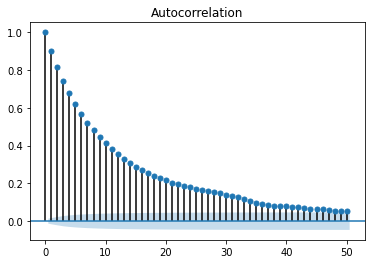

In [186]:
sm.graphics.tsa.plot_acf(samples[:,1], lags=50)
plt.show()

# Retail data

## Import retail data

In [79]:
data = np.loadtxt("../cities_and_regions/data/london_n/shopping_small.txt")
popn = np.loadtxt("../cities_and_regions/data/london_n/popn.txt")
retail_wd0 = np.exp(np.loadtxt("../cities_and_regions/data/london_n/xd0.txt"))
retail_orig_supply = popn[:, 2]/popn[:, 2].sum()
ret_locs = data[:, [0, 1]]
res_locs = popn[:, [0, 1]]

## Plot retail data

In [80]:
# Set plot params
latent_factor = 1000
actual_factor = 10000

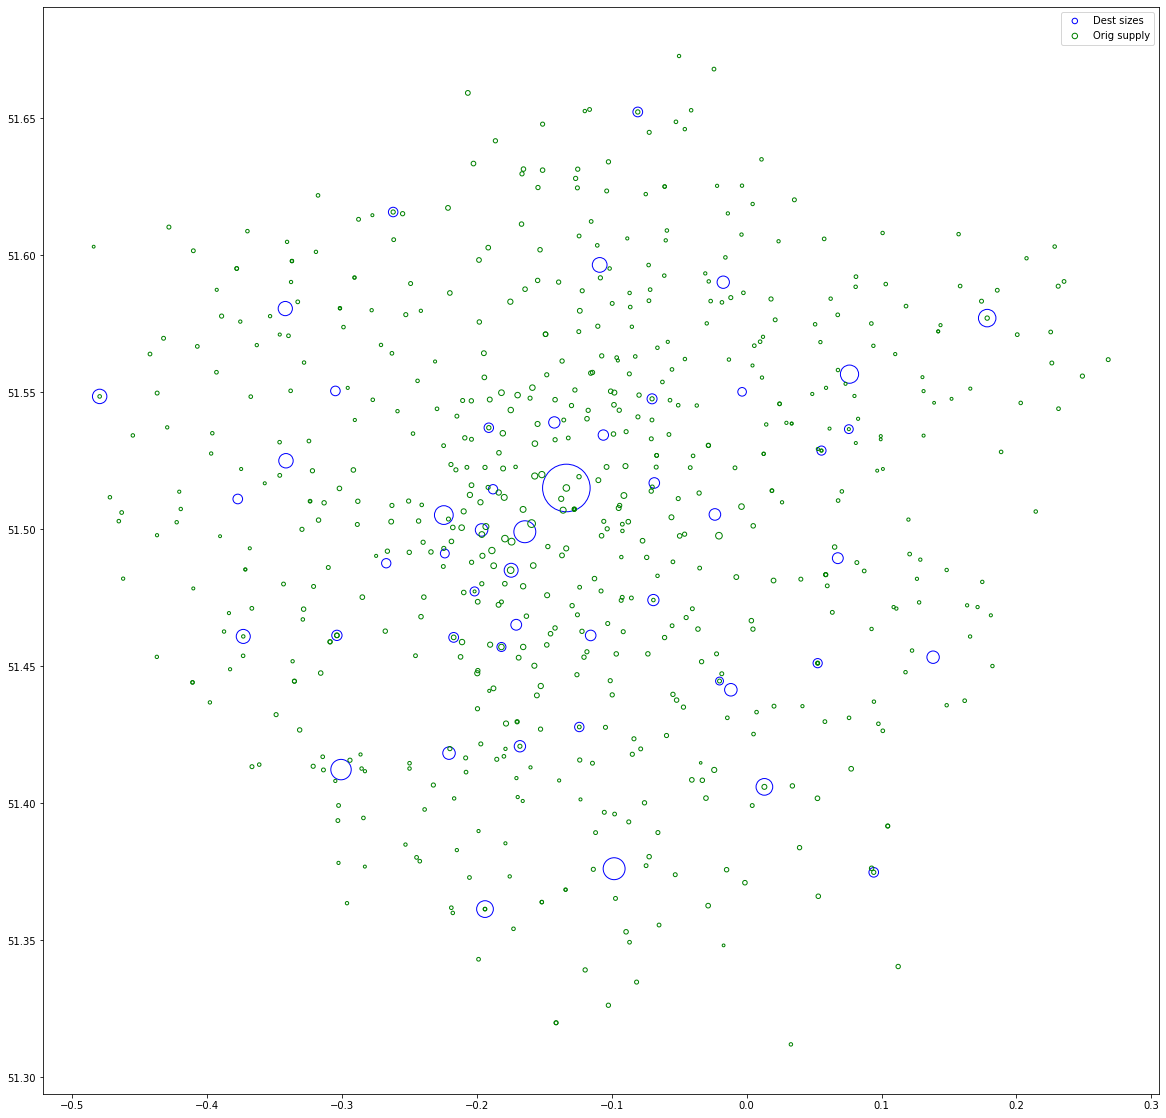

In [81]:
plt.figure(figsize=(20,20))
plt.scatter(ret_locs[:, 1], ret_locs[:, 0], facecolor="None",edgecolors='b', s=actual_factor*retail_wd0, alpha=1,label='Dest sizes')
plt.scatter(res_locs[:, 1], res_locs[:, 0], facecolor="None",edgecolors='g', s=actual_factor*retail_orig_supply, alpha=1,label='Orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]